<a href="https://colab.research.google.com/github/ubaaloyah-byte/sem1/blob/main/Another_copy_of_Assignment_comp_sem_1_v_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#sentiment classification (positive and negative)

In [2]:
!wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt

--2026-01-07 14:00:04--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22322605 (21M) [text/plain]
Saving to: ‘Compiled_Reviews.txt’

Compiled_Reviews.tx 100%[===================>]  21.29M  --.-KB/s    in 0.08s   

2026-01-07 14:00:05 (265 MB/s) - ‘Compiled_Reviews.txt’ saved [22322605/22322605]



In [3]:

import math
import re
import random
from collections import Counter
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

reviews=[]
sentiment_ratings=[]
product_types=[]
helpfulness_ratings=[]

with open("Compiled_Reviews.txt") as f:
   for line in f.readlines()[1:]:
        fields = line.rstrip().split('\t')
        reviews.append(fields[0])
        sentiment_ratings.append(fields[1])
        product_types.append(fields[2])
        helpfulness_ratings.append(fields[3])
#section 1: process data (make all lowercase and remove punct, and tokenise)
#remove most common words that dont relate to reviews. look up top 50 words? such as
#a, an , and etc (usd top 20 from OEC)
#build a vocab list. count all unique words and list in order of popularity

common_words = {
        'the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i', 'it',
    'for', 'not', 'on', 'with', 'he', 'as', 'you', 'do', 'at'
}
processed_review = [
    [t for t in re.sub(r'[^a-z\s]', '', review.lower()).split()
    if t not in common_words]
    for review in reviews
]
def top_vocab(processed_review, max_vocab:int = 1500):
    word_counts = Counter()
    for tokens in processed_review:
        word_counts.update(tokens)

    most_common = word_counts.most_common(max_vocab)
    vocab = {word: idx for idx, (word, _) in enumerate(most_common)}
    vocab['<UNK>'] = len(vocab)

    return vocab, word_counts

#section 2: split data 80% for train and 20% for test
#make bag of word vector for the list of each review -- no!
#use logistic regression (cant get niave baynes to work :///)

data = list(zip(processed_review, sentiment_ratings, product_types, helpfulness_ratings ))

random.seed(9)
random.shuffle(data)
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
test_data = data[split_idx:]

#training set
train_review = [item[0] for item in train_data]
train_sentiment = [item[1] for item in train_data]
train_products = [item[2] for item in train_data]
train_helpfulness = [item[3] for item in train_data]

#test set
test_reviews = [item[0] for item in test_data]
test_sentiment = [item[1] for item in test_data]
test_product = [item[2] for item in test_data]
test_helpfulness = [item[3] for item in test_data]
vocab, _ = top_vocab(train_review, max_vocab=1500)


def train_BoW(token, vocab):
  vector = [0] * len(vocab)
  for word in token:
    if word in vocab:
        idx = vocab[word]
    else:
        idx = vocab["<UNK>"]
    vector[idx] += 1
  return vector

x_train = [train_BoW(tokens, vocab) for tokens in train_review]
y_train = train_sentiment
x_test = [train_BoW(tokens, vocab) for tokens in test_reviews]
y_test =  test_sentiment

#section 3: use niave bayes classifier / logistic regression
#count how often words in dict appear in P and N reviews
#calculate probability then train classifier on training data

M_train = np.array(x_train)
M_test = np.array(x_test)


Y_trainNP = np.array([1 if sentiment == "positive" else 0 for sentiment in y_train])
y_testNP = np.array([1 if sentiment == "positive" else 0 for sentiment in y_test])

vocab_size = M_train.shape[1]
weights = np.random.rand(vocab_size) * 0.01
bias = 0.0
n_iters = 250
lr = 0.005
logistic_loss = []
num_samples = M_train.shape[0]



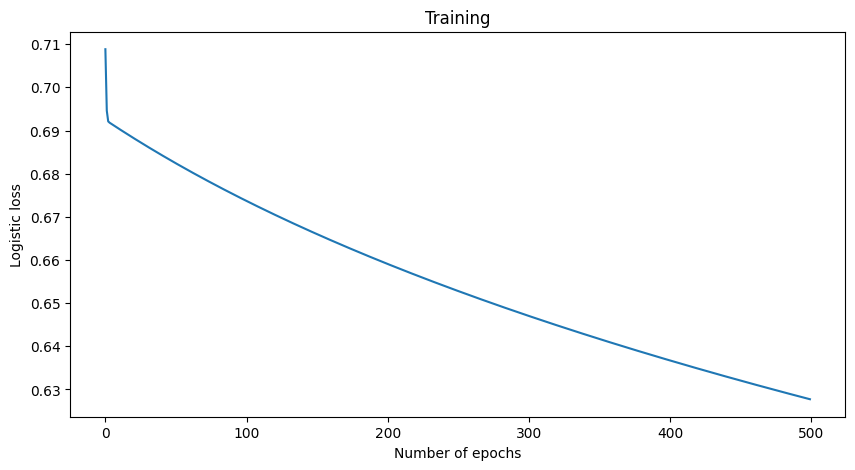

In [15]:
for i in range(n_iters):
  z = np.dot(M_train, weights) + bias
  z = np.clip(z , -500, 500)
  q = 1 / (1 + np.exp(-z))
  eps = 1e-9

  loss = -np.mean(Y_trainNP * np.log(q + eps) + (1 - Y_trainNP) * np.log(1 - q +eps))
  logistic_loss.append(loss)

  dw = np.dot(M_train.T, (q - Y_trainNP)) / num_samples
  db = np.sum(q - Y_trainNP) / num_samples
  weights  = weights - lr *dw
  bias = bias - lr * db

plt.figure(figsize=(10,5))
plt.plot(range(n_iters), logistic_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Logistic loss")
plt.title("Training")
plt.show()




In [27]:
  #section 4:give it the test data and calculate sentiment
#compare prediction and actual
#calculate accuracy = correct / total (error matrix?)
z_test = np.dot(M_test, weights) + bias
z_test = np.clip(z_test, -500, 500)
q_test = 1 / (1 +np.exp(-z_test))

prediction =[int(qi > 0.5) for qi in q_test]
y_test = y_testNP
accuracy = np.sum(prediction == y_test) / len(y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

label_test_pred = ["positive" if s == 1 else "negative" for s in prediction]
TP = sum([int(yp == "positive" and y_test[s] == 1) for s, yp in enumerate (label_test_pred)])
FP = sum([int(yp == "negative" and y_test[s] == 0) for s, yp in enumerate ( label_test_pred)])
TN = sum([int(yp == "negative" and y_test[s] == 0) for s, yp in enumerate (label_test_pred)])
FN = sum([int(yp == "negative" and y_test [s] == 0) for s, yp in enumerate (label_test_pred)])

recall = TP / (TP + FN)
precision = TP / (TP+FP)
accuracy = (TP + TN) / (TP + FP +TN +FN)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

Test Accuracy: 70.23%
Test Accuracy: 66.90%
Precision: 75.26%
Recall: 75.26%
